In [1]:
import fastf1 as f
import fastf1.plotting as p
import tomli
import numpy as np
import pandas as pd 
import seaborn as sns 
import warnings
from math import ceil
from matplotlib import rcParams, pyplot as plt
from pathlib import Path

In [2]:
parent_path = Path.cwd().parent

In [3]:
# connect to cache 
cache_path = parent_path / "Cache"
f.Cache.enable_cache(cache_path)

In [4]:
# plotting setup
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.style.use("dark_background")

In [5]:
# Suppress pandas SettingWithCopy warning
pd.options.mode.chained_assignment = None

# Suppress Seaborn false positive warnings
warnings.filterwarnings("ignore")

In [6]:
# read configs
with open(parent_path / "Data" / "compound_selection.toml", "rb") as toml:
    compound_selection = tomli.load(toml)

with open(parent_path / "Data" / "visualization_config.toml", "rb") as toml:
    visual_config = tomli.load(toml)

visual_config["fresh"]["hatch"]["True"] = None

# Load Dataframes 

In [7]:
def correct_dtype(df_laps):
    """
    Requires: 
    df_laps has the following columns: ["Time", "PitInTime", "PitOutTime", "IsPersonalBest"]
    """

    # convert from object (string) to timedelta
    df_laps[["Time", "PitInTime", "PitOutTime"]] = df_laps[["Time", "PitInTime", "PitOutTime"]].apply(pd.to_timedelta)

    # TrackStatus column makes more sense as strings 
    df_laps["TrackStatus"] = df_laps["TrackStatus"].astype(str)

    # Fill FreshTyre column NAs with "Unknown"
    # Then cast to string 
    # This ensures rows with missing FreshTyre entry will still be plotted
    df_laps["FreshTyre"] = df_laps["FreshTyre"].fillna("Unknown")
    df_laps["FreshTyre"] = df_laps["FreshTyre"].astype(str)

    return df_laps

In [8]:
def load_laps():
    df_dict = {}

    for file in Path.iterdir(parent_path / "Data"):
        if file.suffix == ".csv":
            splits = file.stem.split("_")
            
            if splits[0] == "transformed":
                season = int(splits[2])
                df = pd.read_csv(parent_path / "Data" / file, header=0, index_col=0, true_values=["True"], false_values=["False"])
                correct_dtype(df)
                df_dict[season] = df

    return df_dict

In [9]:
df_dict = load_laps()

# Visualization Functions

In [10]:
def find_legend_order(labels):
    """
    Given the list of labels, return a list of int that specifies their appropriate order in the legend
    
    e.g. labels = ["MEDIUM", "HARD", "SOFT"]
         desired = ["SOFT", "MEDIUM", "HARD"]
         return [2, 0, 1]
         
         labels = ["C3", "C1", "WET"]
         desired = ["C1", "C3", "WET"],
         return [1, 0, 2]
    """
    
    order = []
    old_indices = list(range(len(labels)))
    sorted_labels = []

    if any([name in labels for name in ["HYPERSOFT", "ULTRASOFT", "SUPERSOFT", "SUPERHARD"]]):
        # 2018 absolute compound names
        sorted_labels = visual_config["absolute"]["labels"]["18"]
    elif any([label.startswith("C") for label in labels]):
        # 19_22 absolute compound names
        sorted_labels = visual_config["absolute"]["labels"]["19_22"]
    else:
        # default to relative names
        sorted_labels = visual_config["relative"]["labels"]

    pos = [sorted_labels.index(label) for label in labels]
    order = [old_index for sorted_index, old_index in sorted(zip(pos, old_indices))]
    
    return order

In [11]:
def filter_round_driver(df_laps, round_number, drivers):
    """
    Filter by round number and drivers    
    """
    
    df_laps = df_laps[(df_laps["RoundNumber"] == round_number) & (df_laps["Driver"].isin(drivers))]

    return df_laps

In [12]:
def filter_round_driver_upper(df_laps, round_number, drivers, upper_bound):
    """
    Filter by round number, drivers to include, and lap time upper bound.
    """

    df_laps = df_laps[(df_laps["RoundNumber"] == round_number) & (df_laps["Driver"].isin(drivers)) & (df_laps["PctFromFastest"] < upper_bound)]

    return df_laps

In [13]:
def filter_round_compound_valid_upper(df_laps, round_number, compounds, upper_bound):
    """
    Filter by round number, whether lap is valid, compound name, and lap time upper bound.
    """
    df_laps = df_laps[(df_laps["RoundNumber"] == round_number) & (df_laps["IsValid"]) &
                      (df_laps["Compound"].isin(compounds)) & (df_laps["PctFromFastest"] < upper_bound)]

    return df_laps

In [14]:
def plot_args(season, absolute_compound):
    """
    Given the input argument, return a list of the corresponding arguments to be supplied to the plotting function
    
    Args:
        season: int 
        Championship season 
        
        absolute_compound: bool
            If true, use absolute compound names (C1, C2 ...) in legend
            Else, use relative compound names (SOFT, MEDIUM, HARD) in legend
    
    Returns: tuple
        (hue, palette, marker, labels)
    """    
    if absolute_compound:
        if season == 2018:
            return ("CompoundName",
                    visual_config["absolute"]["palette"]["18"],
                    visual_config["absolute"]["markers"]["18"],
                    visual_config["absolute"]["labels"]["18"]
                    )
        else:
            return ("CompoundName",
                    visual_config["absolute"]["palette"]["19_22"],
                    visual_config["absolute"]["markers"]["19_22"],
                    visual_config["absolute"]["labels"]["19_22"]
                    ) 
    else:
        return ("Compound",
                visual_config["relative"]["palette"],
                visual_config["relative"]["markers"],
                visual_config["relative"]["labels"]
                )

In [15]:
def pick_driver_color(driver):
    # try to use FastF1's driver color
    # if it is not provided, default to white
    if p.DRIVER_TRANSLATE.get(driver, "NA") in p.DRIVER_COLORS:
        return p.DRIVER_COLORS[p.DRIVER_TRANSLATE[driver]]
    else:
        return "#ffffff"

In [16]:
def add_gap(season, driver):
    """
    Add a column containing the gap to the requested driver at the end of each lap 
    """

    df_laps = df_dict[season]
    assert driver.upper() in df_laps["Driver"].unique()
    df_driver = df_laps[df_laps["Driver"] == driver]

    # start a memo
    driver_laptimes = {i:{} for i in df_driver["RoundNumber"].unique()}

    def calculate_gap(row, driver):
        round = row.loc["RoundNumber"]
        lap = row.loc["LapNumber"]

        if lap not in driver_laptimes[round]:
            laptime = df_driver[(df_driver["RoundNumber"] == round) & (df_driver["LapNumber"] == lap)]["Time"]

            if laptime.empty:
                driver_laptimes[round][lap] = pd.NaT
            else:
                driver_laptimes[round][lap] = laptime.iloc[0]

        return (row.loc["Time"] - driver_laptimes[round][lap]).total_seconds()
    
    df_laps[f"Gapto{driver}"] = df_laps.apply(lambda row: calculate_gap(row, driver), axis=1)
    df_dict[season] = df_laps

    return df_laps
           

## Tyre Usage

In [17]:
def make_autopct(values):

    def my_autopct(pct):
        total = sum(values)
        
        # additional call to int is for type conversion
        # not duplicated rounding
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)

    return my_autopct

In [18]:
def get_pie_palette(season, absolute, labels):
    if absolute:
        if season == 2018:
            return [visual_config["absolute"]["palette"]["18"][label] for label in labels]
        else:
            return [visual_config["absolute"]["palette"]["19_22"][label] for label in labels]
    else:
        return [visual_config["relative"]["palette"][label] for label in labels]


In [19]:
def make_pie_title(season, slick_only):
    if slick_only:
        return f"Slick Compound Usage in the {season} Season"
    else:
        return f"All Compound Usage in the {season} Season"

In [20]:
def tyre_usage_pie(season, title=None, events=None, drivers=None, slick_only=True, absolute_compound=True):
    
    """
    Visualize tyre usage trends in select races or an entire season with pie chart
    
    Args:
        season: int {2021, 2022}
            Championship season
        
        title: str, default:None
            Use the default argument to get an automatically formatted title
            (Only available when events and drivers are both None)
            
        events: list, default: None
            A list containing the round number (as int) or the names of events
            e.g. [1, "Hungary", "British Grand Prix", "Monza"]
            Name fuzzy matching provided by fastf1.get_event()
            Using the default value will select all events
            
        drivers: list, default:None
            A list containing three-letter driver abbreviations 
            e.g. ["VER", "HAM"]
            Using the default value will select all drivers
            
        slick_only: bool, default:True
            If true, only laps raced on slick tyres are counted
            If false, all laps are counted
            
        absolute_compound: bool, default:True
            If true, group tyres by their absolute compound names (C1, C2 etc.)
            If false, group tyres by their names in the respective events (SOFT, MEDIUM, HARD)
          
    Returns: Figure object
    """    
    included_laps = df_dict[season]

    if title is None and events is None and drivers is None:
        title = make_pie_title(season, slick_only)
    
    if events is None:
        events = pd.unique(included_laps["RoundNumber"])
    else:
        events = [f.get_event(season, event)["RoundNumber"] if isinstance(event, str) else event for event in events]
        
    if drivers is None:
        drivers = pd.unique(included_laps["Driver"])

    if slick_only:
        included_laps = included_laps[included_laps["IsSlick"] == True]


    included_laps = included_laps[(included_laps["RoundNumber"].isin(events)) & (included_laps["Driver"].isin(drivers))]
    
    fig, ax = plt.subplots(figsize=(10,6))
    plt.style.use("default")

    lap_counts = None 
    if absolute_compound:
        lap_counts = included_laps.groupby("CompoundName").size()
    else:
        lap_counts = included_laps.groupby("Compound").size()

    labels = lap_counts.index
    palette = get_pie_palette(season, absolute_compound, labels)
    
    wedges, texts, autotexts = ax.pie(x=lap_counts.values,  
                                        labels=labels, 
                                        colors=palette, 
                                        autopct=make_autopct(lap_counts), 
                                        counterclock=False, 
                                        startangle=90)

    handles, labels = ax.get_legend_handles_labels()
    label_order = find_legend_order(labels)
    ax.legend(handles=[handles[i] for i in label_order],
              labels=[labels[i] for i in label_order], 
              title="Compound Names", 
              loc="best")
              
    ax.axis("equal")
    ax.set_title(title)
    plt.setp(autotexts, size=12)
    plt.show()
    
    return fig

## Driver Stats Scatterplot

In [21]:
def driver_stats_scatterplot(season, event, drivers=3, y="LapTime", upper_bound=10, absolute_compound=False):
    """
    Plot driver data during a race
            
    Args:
        season: int 
            Championship season
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list or int, default:3
            If a list is used, it should contain the three letter abbreviations
            of the drivers to be plotted
            If a int is used, the top {int} drivers' strategies will be plotted 
            If None, all drivers are plotted
            By default, only the podium finishers are plotted

        y: str, default: LapTime
            Name of the column to be used as the y-axis.
            
        upper_bound: float, default: 10
            The upper bound on PctFromFastest for included laps
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: False
        
    Returns: Figure
    """    
        
    plt.style.use("dark_background")
    fontdict = {'fontsize': rcParams['axes.titlesize'],
                'fontweight': rcParams['axes.titleweight'],
                'color': rcParams['axes.titlecolor'],
                'verticalalignment': 'baseline',
                'horizontalalignment': "center"}

    event_info = f.get_event(season, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]

    args = plot_args(season, absolute_compound)    
    included_laps = df_dict[season]

    if drivers is None:
        drivers= 20
    
    if isinstance(drivers, int):
        drivers = included_laps[included_laps["RoundNumber"] == round_number]["Driver"].unique()[:drivers]

    included_laps = filter_round_driver(included_laps, round_number, drivers)
    
    max_width = 4    
    num_row = ceil(len(drivers) / max_width)
    num_col = len(drivers) if len(drivers) < max_width else max_width
    fig, axes = plt.subplots(nrows=num_row, ncols=num_col, sharey=True, sharex=True, figsize=(5*num_col, 5*num_row))

    # Prevent TypeError when only one driver is plotted
    if len(drivers) == 1:
        axes = np.array([axes])

    # LapRep columns have outliers that can skew the graph y-axis
    # The high outlier values are filtered by upper_bound 
    # Using a lower bound of -5 on PctFromLapRep will retain 95+% of all laps 
    if y == "PctFromLapRep" or y == "DeltaToLapRep":
        included_laps = included_laps[included_laps["PctFromLapRep"] > -5]
        
    for index, driver in enumerate(drivers):
        row = index // max_width
        col = index % max_width
        
        ax = axes[row][col] if num_row > 1 else axes[col]
        
        driver_laps = included_laps[included_laps["Driver"]==driver]
        pit_in_laps = driver_laps[driver_laps["PitInTime"].notnull()]["LapNumber"].to_numpy()
        
        # After pitstops are identified, we can filter out laps that doesn't meet the upper_bound
        driver_laps = driver_laps[driver_laps["PctFromFastest"] < upper_bound]

        if driver_laps.shape[0] < 5:
            print(f"WARNING: {driver} HAS LESS THAN 5 LAPS ON RECORD FOR THIS EVENT")
        
        sns.scatterplot(data=driver_laps, 
                        x="LapNumber", 
                        y=y, 
                        ax=ax, 
                        hue=args[0], 
                        palette=args[1],
                        hue_order=args[3],
                        style="FreshTyre",
                        style_order = ["True", "False", "Unknown"],
                        markers=visual_config["fresh"]["markers"],
                        legend='auto' if index == num_col-1 else False
                        )
        
        ax.vlines(ymin=plt.yticks()[0][1], ymax=plt.yticks()[0][-2], x=pit_in_laps, label="Pitstop", linestyle="dashed")

        driver_color = pick_driver_color(driver)
        fontdict["color"] = driver_color 
        ax.set_title(label=driver, fontdict=fontdict, fontsize=12)
        
        ax.grid(color=driver_color, which='both', axis='both')
        sns.despine(left=True, bottom=True)
                
    fig.suptitle(t=f"{season} {event_name}", fontsize=20)
    axes.flatten()[num_col-1].legend(loc='best', fontsize=8, framealpha=0.5)
    plt.show()
    
    return fig

## Driver Stats Lineplot

In [22]:
def driver_stats_lineplot(season, event, drivers=3, y="Position", upper_bound=10):
    """
    Plot driver data during a race
            
    Args:
        season: int 
            Championship season
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list or int, default:3
            If a list is used, it should contain the three letter abbreviations
            of the drivers to be plotted
            If a int is used, the top {int} drivers' strategies will be plotted 
            If None, all drivers are plotted
            By default, only the podium finishers are plotted

        y: str, default: Position
            Name of the column to be used as the y-axis.

        upper_bound: int, default: 10
            Only laps whose lap time is no more than <upper_bound>% slower than the fastest lap time will be plotted.
        
    Returns: Figure
    """    
        
    plt.style.use("dark_background")
    fontdict = {'fontsize': rcParams['axes.titlesize'],
                'fontweight': rcParams['axes.titleweight'],
                'color': rcParams['axes.titlecolor'],
                'verticalalignment': 'baseline',
                'horizontalalignment': "center"}

    event_info = f.get_event(season, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]

    included_laps = df_dict[season]

    if drivers is None:
        drivers= 20
    
    if isinstance(drivers, int):
        drivers = included_laps[included_laps["RoundNumber"] == round_number]["Driver"].unique()[:drivers]

    included_laps = filter_round_driver_upper(included_laps, round_number, drivers, upper_bound)
    
    # adjust plot size based on number of laps
    num_laps = included_laps["LapNumber"].nunique()
    fig, ax = plt.subplots(figsize=(ceil(num_laps*0.25), 8))
    ax.invert_yaxis()

    if len(drivers) > 10:
        ax.grid(which='major', axis='x')
    else:
        ax.grid(which="major", axis="both")

    for driver in drivers:        
        driver_laps = included_laps[included_laps["Driver"]==driver]
        driver_color = pick_driver_color(driver)

        sns.lineplot(driver_laps, x="LapNumber", y=y, ax=ax, color=driver_color, errorbar=None)
        plt.grid(axis="x")
        last_lap = driver_laps["LapNumber"].max()
        last_pos = driver_laps[y][driver_laps["LapNumber"] == last_lap].iloc[0]
        
        ax.annotate(xy=(last_lap + 1, last_pos + 0.25), text=driver, color=driver_color, fontsize=12)
        sns.despine(left=True, bottom=True) 

    fig.suptitle(t=f"{season} {event_name}", fontsize=20)
    plt.show()
    
    return fig

## Tyre Strategy Barplot

### Tyre Strategy for Selected Drivers

In [23]:
# WARNING: A row may fall under both categories

def lap_filter_sc(row):
    # if track status column includes 4
    # at least part of the lap is under safety car
    # may slightly overcount
    return "4" in row.loc["TrackStatus"]

def lap_filter_vsc(row):
    # track status = 6 is VSC deployed
    # track status = 7 is VSC ending 
    # check if any part of the lap falls into either category 
    return ("6" in row.loc["TrackStatus"]) or ("7" in row.loc["TrackStatus"])

def find_sc_laps(df_laps):
    # df should be rows from a single event 
    # at the minimum, both LapNumber and TrackStatus has to be present 

    sc_laps = np.sort(df_laps[df_laps.apply(lap_filter_sc, axis=1)]["LapNumber"].unique())
    vsc_laps = np.sort(df_laps[df_laps.apply(lap_filter_vsc, axis=1)]["LapNumber"].unique())

    return sc_laps, vsc_laps

In [24]:
def shade_sc_periods(sc_laps, VSC=False):
    """
    Shade SC periods lasting at least one lap on the current figure
    
    Args:
        sc_laps: array-like
            Array of integers indicating laps under SC or VSC 
    """

    sc_laps_copy = np.append(sc_laps, [-1])

    start = 0
    end = 1 

    while end < len(sc_laps_copy):
        # check if two SC laps are continuous
        if sc_laps_copy[end] == sc_laps_copy[end-1] + 1:
            end += 1
        else:
            # current SC period has ended
            # if the period is at least one full lap 
            if end - start > 1:
                # minus one to correct for zero indexing on the plot 
                # but one indexing in the data 
                plt.axvspan(xmin=sc_laps_copy[start]-1, 
                            xmax=sc_laps_copy[end-1]-1,
                            alpha=0.5,
                            color="orange",
                            hatch="-" if VSC else None,
                            label="VSC" if VSC else "SC"
                            )
                
            start = end 
            end += 1

    return None

In [25]:
def strategy_barplot(season, event, drivers=None, absolute_compound=False):
    """
    Plot the tyre strategy during a race
            
    Args:
        season: int
            Championship season
            
        event: int or str
            Round number or name of the event
            Name is fuzzy matched by fastf1.get_event()
        
        drivers: list or int, default: None
            If a list is used, it should contain the three letter abbreviations
            of the drivers to be plotted
            If a int is used, the top {int} drivers' strategies will be plotted 
            If None, all drivers are plotted
        
        absolute_compound: bool, default: False
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure
    """    

    event_info = f.get_event(season, event)
    round_number = event_info["RoundNumber"]
    event_name = event_info["EventName"]        
    
    included_laps = df_dict[season]
    
    if drivers == None:
        drivers = included_laps[included_laps["RoundNumber"] == round_number]["Driver"].unique()
    elif isinstance(drivers, int):
        drivers = included_laps[included_laps["RoundNumber"] == round_number]["Driver"].unique()[:drivers]
    
    included_laps = filter_round_driver(included_laps, round_number, drivers)

    fig, ax = plt.subplots(figsize=(5, len(drivers)//2 + 1))    
    plt.style.use("dark_background")

    driver_stints = included_laps[['Driver', 'Stint', "Compound", "CompoundName", "FreshTyre", "LapNumber"]].groupby(['Driver', 'Stint', "Compound", "CompoundName", "FreshTyre"]).count().reset_index()
    driver_stints = driver_stints.rename(columns={"LapNumber":"StintLength"})
    driver_stints = driver_stints.sort_values(by=['Stint'])

    args = plot_args(season, absolute_compound)

    for driver in drivers:
        stints = driver_stints.loc[driver_stints['Driver'] == driver]
        
        previous_stint_end = 0
        for idx, stint in stints.iterrows():
            plt.barh([driver], 
                     stint['StintLength'], 
                     left=previous_stint_end, 
                     color=args[1][stint[args[0]]], 
                     edgecolor = "black",
                     fill=True,
                     hatch=visual_config["fresh"]["hatch"][stint["FreshTyre"]]
                    )
                    
            previous_stint_end += stint['StintLength']

    # shade safety car (both SC and VSC) periods 
    # only safety car lasting at least one full lap will be shown
    # if a lap falls under both category, SC takes precedence
    sc_laps, vsc_laps = find_sc_laps(included_laps)
    vsc_laps = [lap for lap in vsc_laps if lap not in sc_laps]

    shade_sc_periods(sc_laps)
    shade_sc_periods(vsc_laps, VSC=True)

    plt.title(f"{season} {event_name}", fontsize=16)
    plt.xlabel('Lap Number')
    plt.grid(False)

    handles, labels = ax.get_legend_handles_labels()
    if labels:
        deduplicate_labels_handles = dict(zip(labels, handles))
        plt.legend(handles=deduplicate_labels_handles.values(),
                   labels=deduplicate_labels_handles.keys(),
                   loc="lower right", 
                   fontsize=10
                  )

    # Invert y-axis 
    ax.invert_yaxis()

    # Remove frame from plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()
    
    return fig

### Compound Head-to-Head Line Chart

In [26]:
def convert_compound_names(season, round_number, compounds):
    """
    Convert relative compound names to absolute names 
    
    Args:
        season: int
        Championship season 

        round_number: int

        compounds: list of relative compound names
    
    Returns:
        comp_names: tuple of absolute compound names
        
    """
    compound_to_index = {"SOFT":2, "MEDIUM":1, "HARD":0}
    if season == 2018:
        compound_to_index = {"SOFT":0, "MEDIUM":1, "HARD":2}

    return_vals = []
            
    for compound in compounds:
        return_vals.append(compound_selection[str(season)][str(round_number)][compound_to_index[compound]])
    
    return tuple(return_vals)


In [27]:
def process_input(seasons, events, y, compounds, x, upper_bound, absolute_compound):
    """
    Sanitize input parameters seasons, events, compound, and x 

    Show related warnings and carry necessary assertions 

    Returns:
        event_objects: list of FastF1.Event 
        list of event objects corresponding to each requested race 

        included_laps_lst: list of pd.DataFrame
        list of dataframes corresponding to each requested race
    """
    # unpack
    compounds = [compound.upper() for compound in compounds]

    for compound in compounds:
        assert compound in ["SOFT", "MEDIUM", "HARD"], f"requested compound {compound} is not valid"
        
    if x != "LapNumber" and x != "TyreLife":
        print(f'Using {x} as the x-axis is not recommended. The recommended arguments are LapNumber and TyreLife')

    assert seasons and events and len(seasons) == len(events), f"num seasons ({len(seasons)}) does not match num events ({len(events)})"

    if not absolute_compound and len(events) > 1:
        print('''
              WARNING: Different events may use different compounds under the same name!
                       e.g. SOFT may be any of C3 to C5 dependinging on the event
              '''
              )
    
    # Combine seasons and events and get FastF1 event objects
    event_objects = [f.get_event(seasons[i], events[i]) for i in range(len(seasons))]
    included_laps_lst = []
        
    for season, event in zip(seasons, event_objects):
        df_laps = filter_round_compound_valid_upper(df_dict[season], event['RoundNumber'], compounds, upper_bound)

        # LapRep columns have outliers that can skew the graph y-axis
        # The high outlier values are filtered by upper_bound 
        # Using a lower bound of -5 on PctFromLapRep will retain 95+% of all laps 
        if y == "PctFromLapRep" or y == "DeltaToLapRep":
            df_laps = df_laps[df_laps["PctFromLapRep"] > -5]

        included_laps_lst.append(df_laps)

    return event_objects, included_laps_lst

In [28]:
def compounds_lineplot(seasons, events, y="LapTime", compounds=["SOFT", "MEDIUM", "HARD"], x="TyreLife", upper_bound=10, absolute_compound=True):
    """
    Visualize performance of each compound over time
        
    Caveats:
        Only laps with IsValid=True are considered
    
    Args:
        seasons: list of int or str
            Championship seasons of the events
        
        events: list of int or str
            A mix of round numbers or names of the events
            Name is fuzzy matched by fastf1.get_event()
        
        Each (season, event) pair should uniquely identify an event
        
        y: str, default: "LapTime"
            The column to use as the y-axis.
        
        compounds: list of str {"SOFT", "MEDIUM", "HARD"}, default: ["SOFT", "MEDIUM", "HARD"]
            The compounds in the head-to-head
            
        x: str {"TyreLife", "LapNumber"} recommended, default: "TyreLife"
            The column to use as the x-axis

        upper_bound: float, default: 10
           The upper bound on PctFromFastest for included laps
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: True
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure, Warnings
    """

    plt.style.use("dark_background")

    event_objects, included_laps_lst = process_input(seasons, events, y, compounds, x, upper_bound, absolute_compound)

    fig, axes = plt.subplots(nrows=len(event_objects), sharex=True, ncols=1, figsize=(5, 5*len(event_objects)))
    
    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]
                    
    # Copy compounds values
    # May need to convert from relative to absolute names when plotting
    compounds_copy = compounds.copy()

    # store warnings for compounds that are requested but not plotted
    warning_msgs = []
 
    for i in range(len(event_objects)):
        args = plot_args(seasons[i], absolute_compound)
        included_laps = included_laps_lst[i]
        medians = included_laps.groupby([args[0], x])[y].median()

        round_number = event_objects[i]["RoundNumber"]
        event_name = event_objects[i]["EventName"]
        
        if absolute_compound:
            compounds_copy = convert_compound_names(seasons[i], round_number, compounds)
                            
        for compound in compounds_copy:
            if compound in medians.index:
                ax = sns.lineplot(x=medians.loc[compound].index, 
                                  y=medians.loc[compound].values, 
                                  ax=axes[i], 
                                  color=args[1][compound],
                                  marker=args[2][compound],
                                  markersize=4,
                                  label=compound
                                )
            else:
                warning_msgs.append(f"{compounds[i]} is not plotted for {seasons[i]} {event_name} because there is not enough data")

        ax.set_ylabel(y, fontsize=12)
                   
        handles, labels = axes[i].get_legend_handles_labels()
        order = find_legend_order(labels)
        axes[i].legend(handles=[handles[idx] for idx in order], 
                       labels=[labels[idx] for idx in order], 
                       loc="best", 
                       title=args[0],
                       frameon=True,
                       fontsize=10,
                       framealpha=0.5
                       )
        
        ax.set_title(label=f"{seasons[i]} {event_name}", fontsize=12)
        ax.grid(which="both", axis='y')
        sns.despine(left=True, bottom=True)
                
    # reorder compound names for title
    compounds = [compounds[i] for i in find_legend_order(compounds)]
    
    fig.suptitle(t=" VS ".join(compounds), fontsize=14)
    plt.show()
    
    return fig, warning_msgs

### Compound Head-to-Head Distribution

In [29]:
def compounds_distribution(seasons, events, y="LapTime", compounds=["SOFT", "MEDIUM", "HARD"], violin_plot=False, x="TyreLife", upper_bound=10, absolute_compound=True):
    """
    Plot boxplot for selected y axis by event
        
    Caveats:
        Only laps with IsValid=True are considered
    
    Args:
        seasons: list of int or str
            Championship seasons of the races
        
        events: list of int or str
            A mix of round numbers or names of the events
            Name is fuzzy matched by fastf1.get_event()
        
        (each (season, event) pair should uniquely identify an event)
        
        y: str, default: "LapTime"
            The column to use as the y-axis.
        
        compounds: list of str {"SOFT", "MEDIUM", "HARD"}, default: ["SOFT", "MEDIUM", "HARD"]
            The compounds in the head-to-head

        violin_plot: bool, default: False
            If True, makes violin plots. Else make boxplots
            
        x: str {"TyreLife", "LapNumber"} recommended, default: "TyreLife"
            The column to use as the x-axis

        upper_bound: float, default: 10
            The upper bound on PctFromFastest for included laps
            
            e.g. By default, only laps that are no more than 10% slower than the fastest lap are plotted 
        
        absolute_compound: bool, default: True
            If True, use absolute compound palette (C1, C2 etc.)
            
            If False, use relative compound palette (SOFT, MEDIUM, HARD)
        
    Returns: Figure, Warnings
    """
    
    plt.style.use("dark_background")

    event_objects, included_laps_lst = process_input(seasons, events, y, compounds, x, upper_bound, absolute_compound)

    # adjust plot size based on the chosen x-axis
    x_ticks = max([laps[x].nunique() for laps in included_laps_lst])
    fig, axes = plt.subplots(nrows=len(event_objects), sharex=True, ncols=1, figsize=(ceil(x_ticks*0.75), 5*len(event_objects)))
    
    # Prevent TypeError when only one event is plotted
    if len(events) == 1:
        axes = [axes]
                    
    # Copy compounds values
    # May need to convert from relative to absolute names when plotting
    compounds_copy = compounds.copy()

    # store warnings for compounds that are requested but not plotted
    warning_msgs = []
 
    for i in range(len(event_objects)):
        args = plot_args(seasons[i], absolute_compound)
        included_laps = included_laps_lst[i]

        plotted_compounds = included_laps["Compound"].unique()
        event_name = event_objects[i]["EventName"]

        for compound in compounds:
            if compound not in plotted_compounds:
                warning_msgs.append(f"{compound} is not plotted for {seasons[i]} {event_name} because there is no valid lap time data")

        if violin_plot:
            ax = sns.violinplot(data=included_laps,
                                x=x,
                                y=y,
                                ax=axes[i],
                                hue=args[0],
                                palette=args[1])
        else:
            ax = sns.boxplot(data=included_laps,
                             x=x,
                             y=y,
                             ax=axes[i],
                             hue=args[0],
                             palette=args[1])

        ax.set_ylabel(y, fontsize=12)
        xticks = ax.get_xticks()
        xticks = [tick+1 for tick in xticks if tick % 5 == 0]
        ax.set_xticks(xticks)
        ax.grid(which='both', axis='y')
                       
        handles, labels = axes[i].get_legend_handles_labels()
        order = find_legend_order(labels)
        axes[i].legend(handles=[handles[idx] for idx in order], 
                       labels=[labels[idx] for idx in order], 
                       loc="best", 
                       title=args[0],
                       frameon=True,
                       fontsize=12,
                       framealpha=0.5)
        
        ax.set_title(label=f"{seasons[i]} {event_name}", fontsize=12)
        sns.despine(left=True, bottom=True)
    
    # reorder compound names for title
    compounds = [compounds[i] for i in find_legend_order(compounds)]
    
    fig.suptitle(t=" VS ".join(compounds), fontsize="16")
    plt.show()
    
    return fig, warning_msgs

## Examples

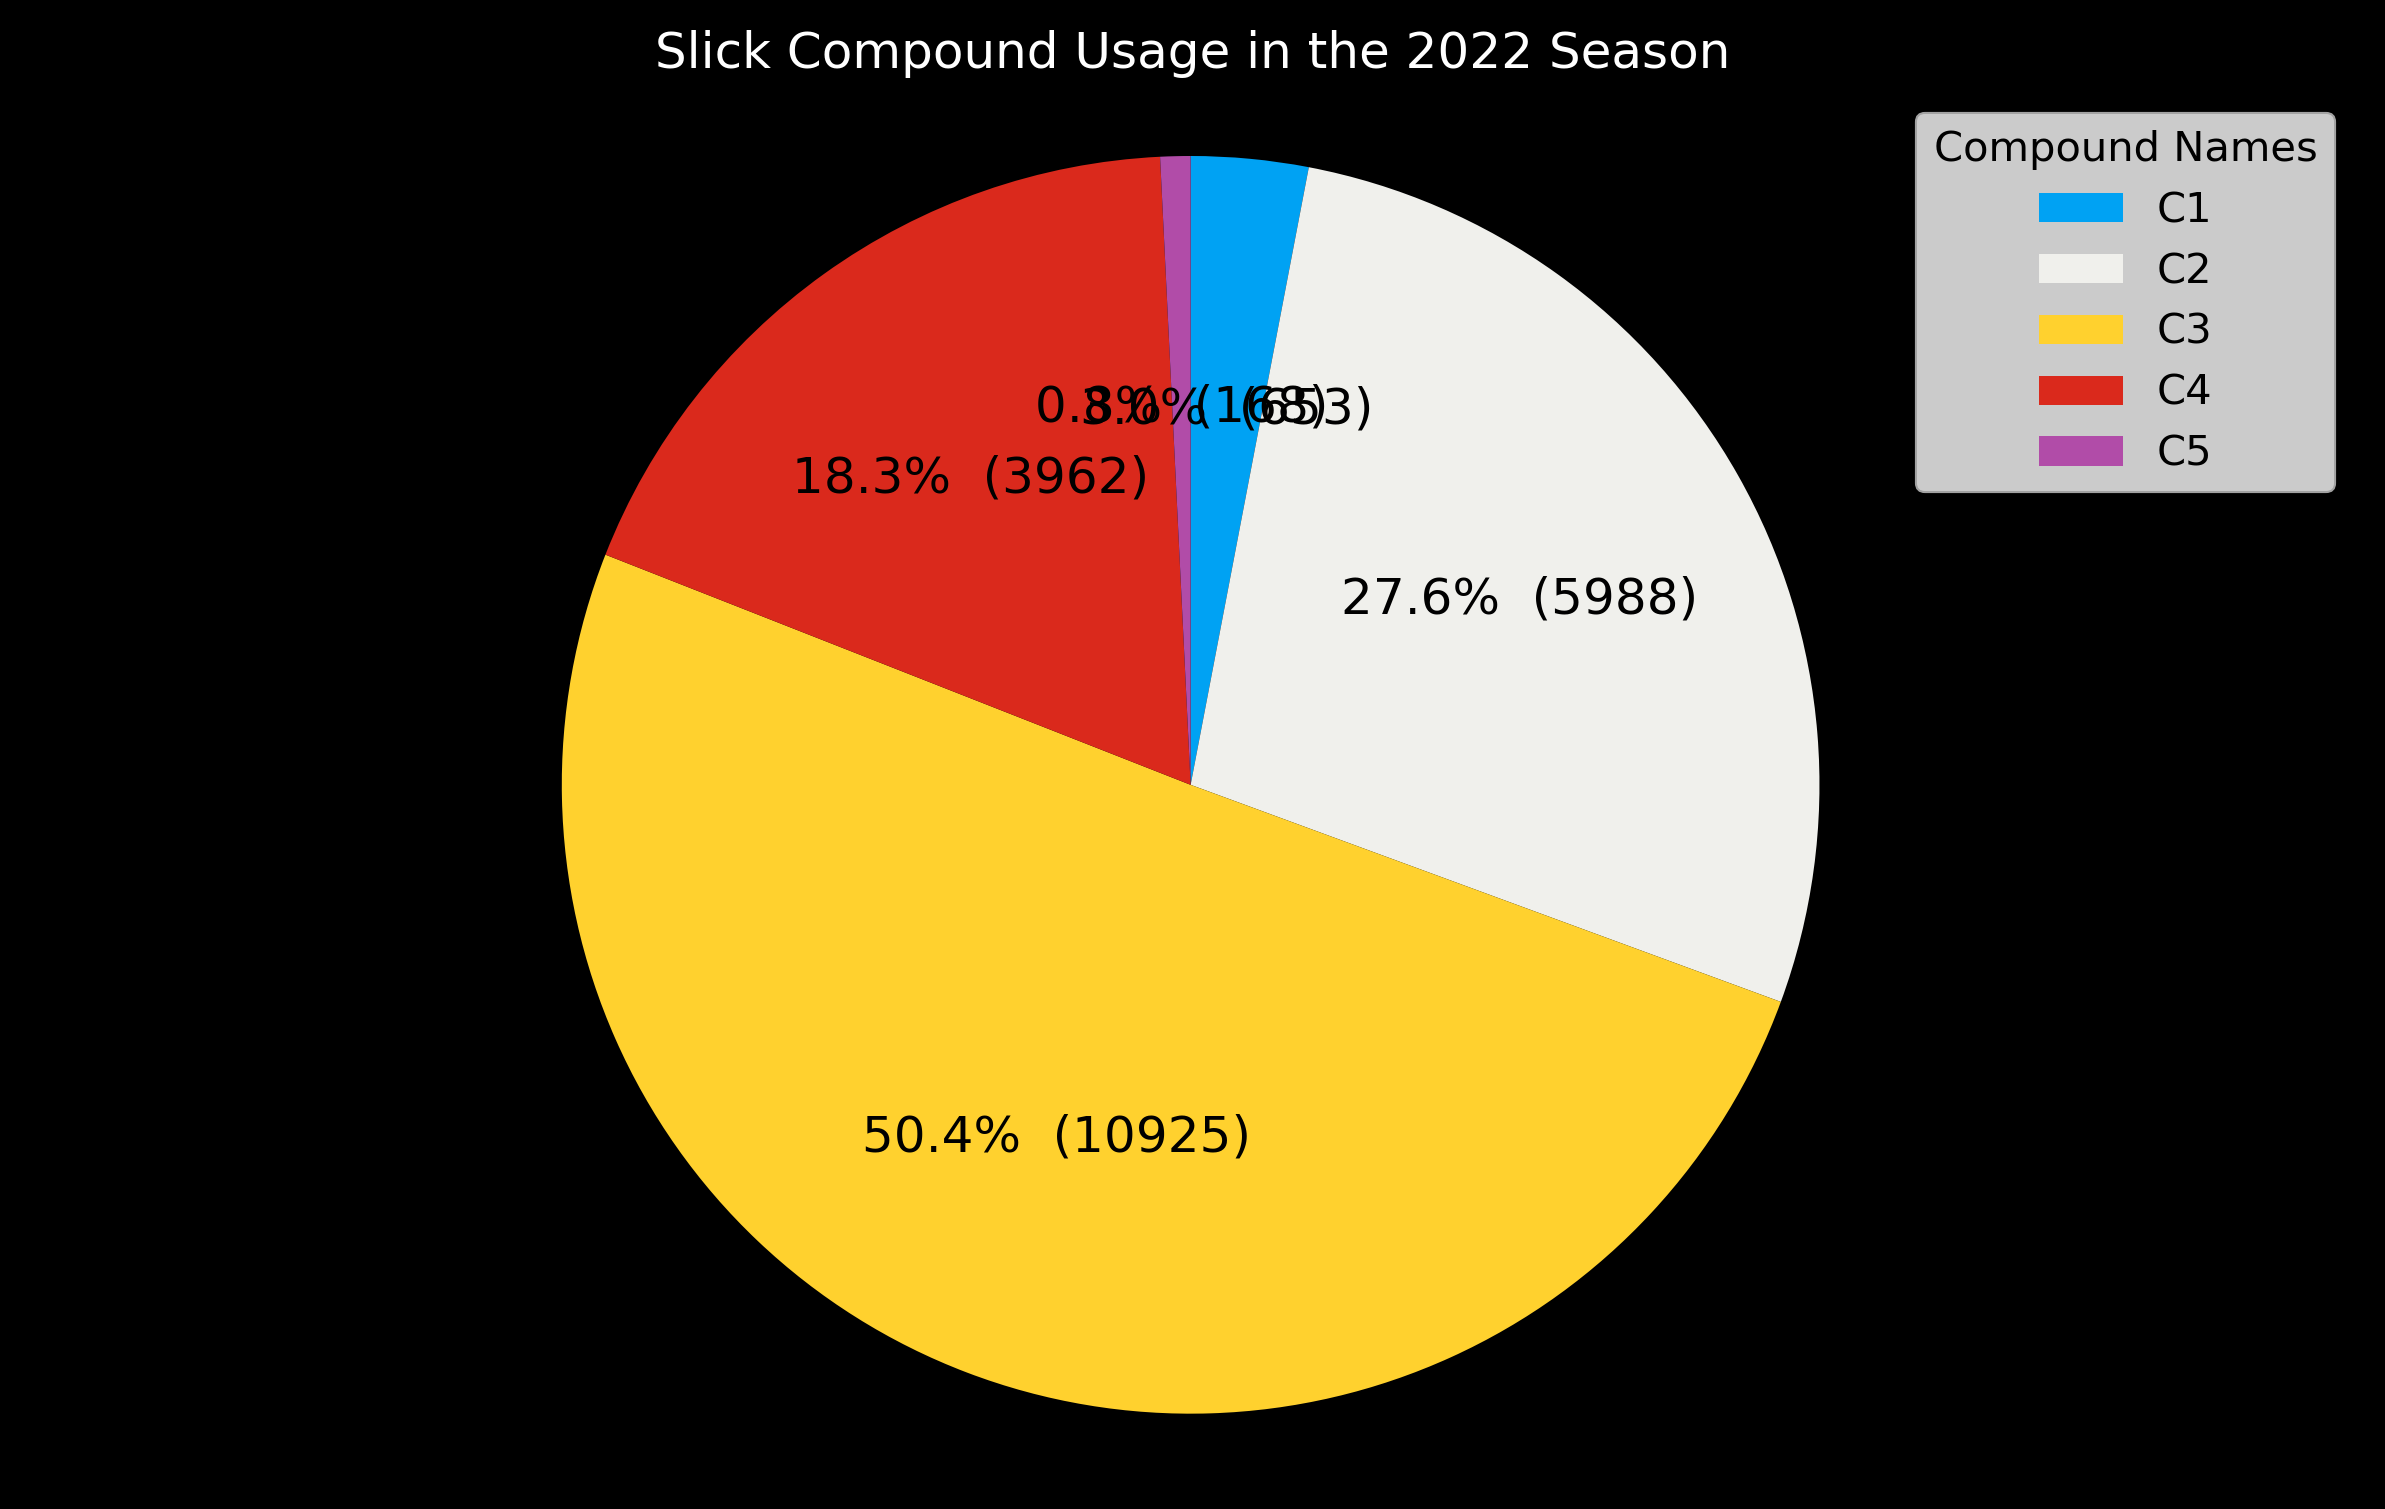

In [30]:
# How often are each slick compound used in the 2022 season?
pie_chart = tyre_usage_pie(season=2022, 
                           title=None, 
                           events=None, 
                           drivers=None, 
                           slick_only=True, 
                           absolute_compound=True
                          )

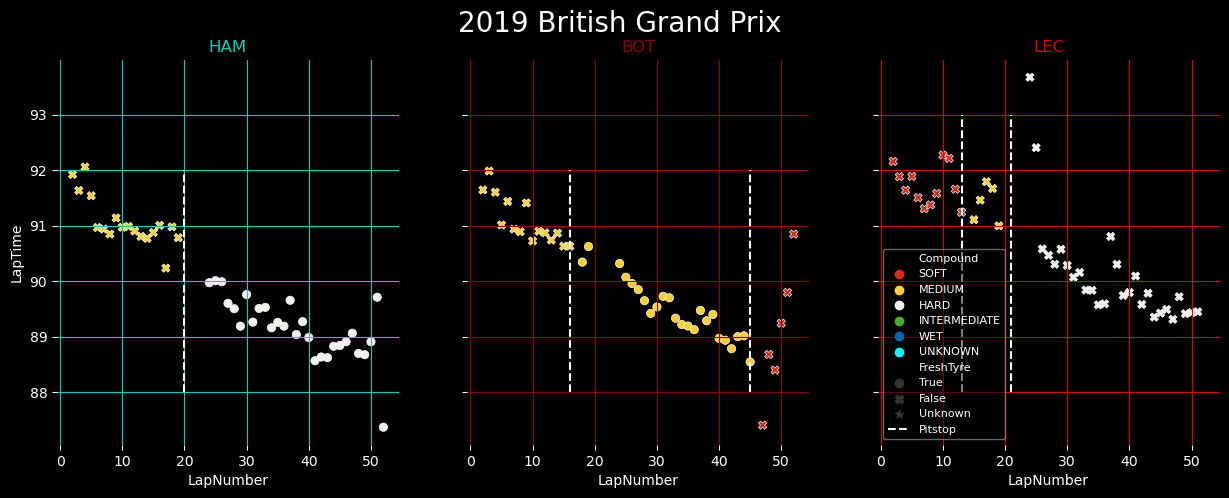

In [31]:
# What was the lap times of the podium finishers in the 2019 British Grand Prix?
lap_time_plot = driver_stats_scatterplot(season=2019, 
                                         event="Silverstone", 
                                         drivers=3, 
                                         y="LapTime", 
                                         upper_bound=10, 
                                         absolute_compound=False
                                        )

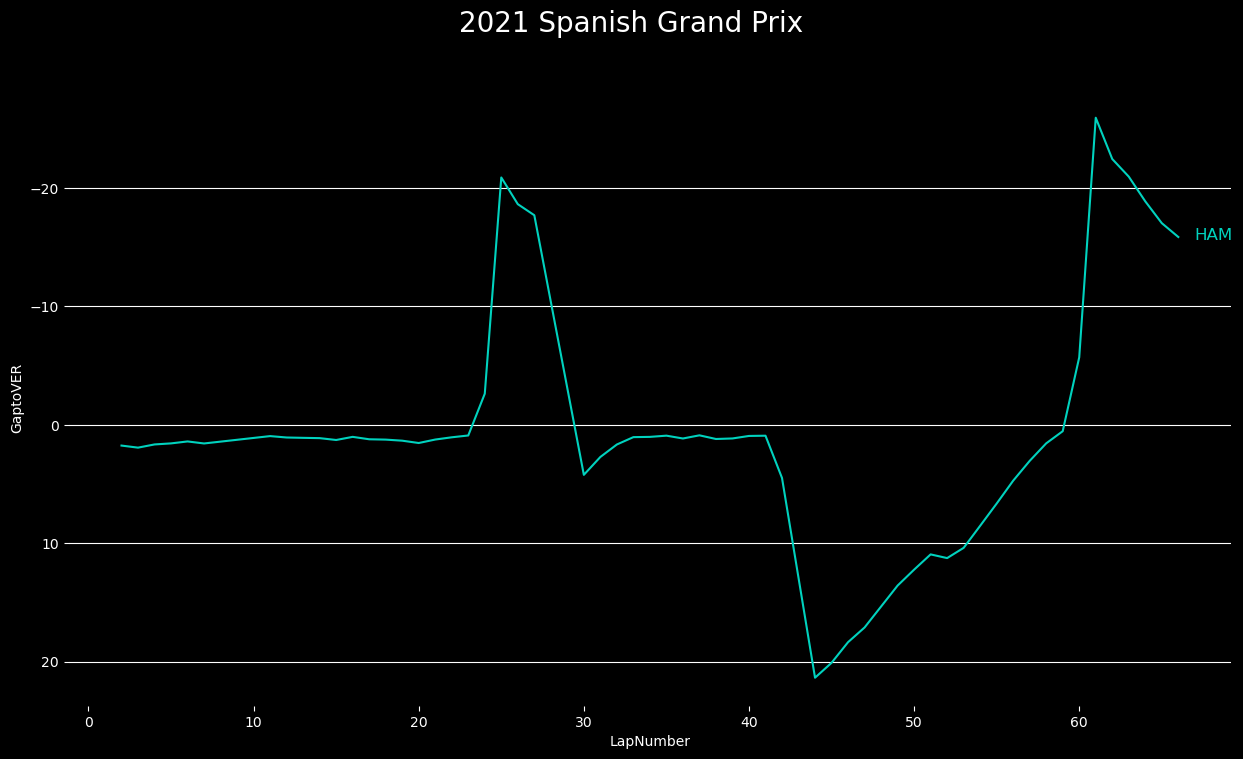

In [32]:
# Show me how Hamilton beat Verstappen in 2021 Spanish Grand Prix with a two stop strategy
add_gap(2021, 'VER')
lap_time_plot = driver_stats_lineplot(season=2021, 
                                      event="Spin", 
                                      drivers=["HAM"], 
                                      y="GaptoVER"
                                     )

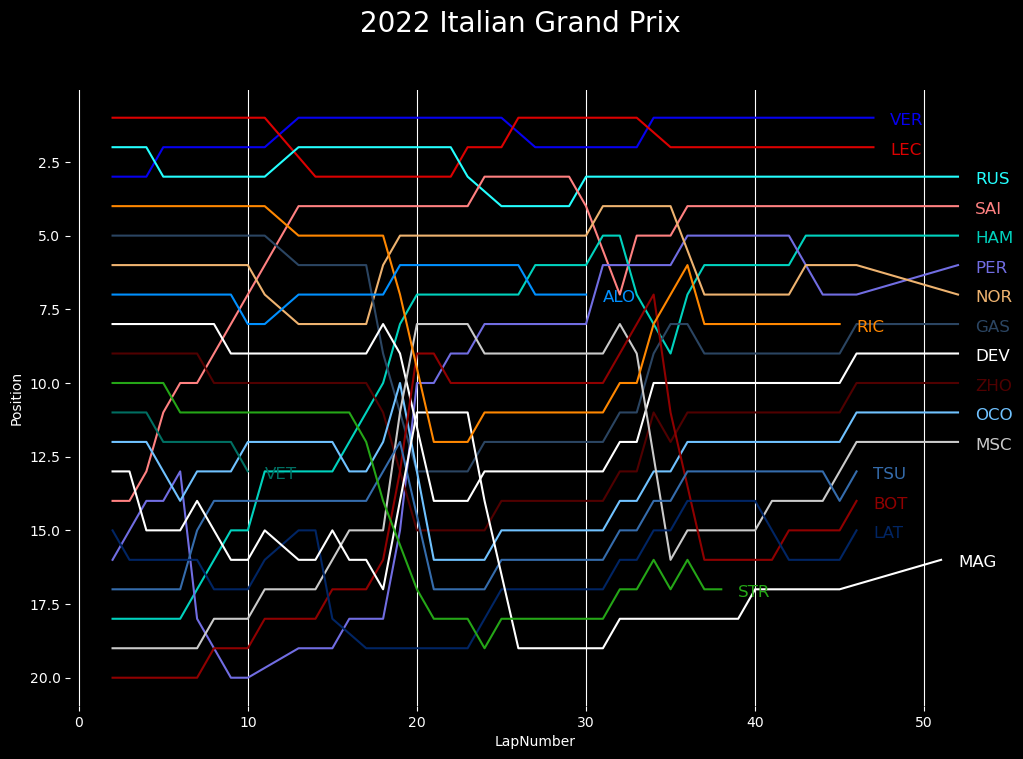

In [33]:
# Show me Sainz's recovery drive (14 places gained) in the 2022 Italian Grand Prix
position_plot = driver_stats_lineplot(season=2022,
                                      event="Monza",
                                      drivers=None, 
                                      y="Position"
                                     )

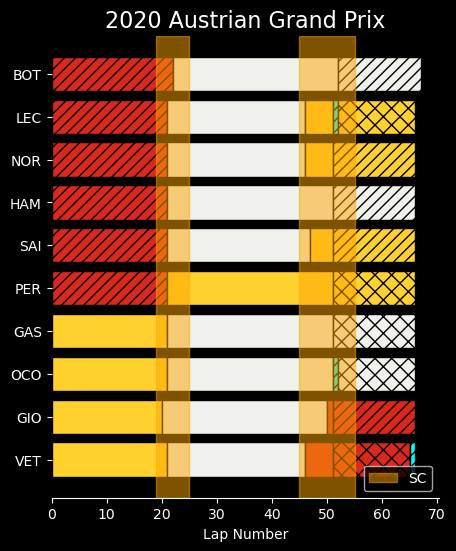

In [34]:
# What strategies did each of the top 10 driver use in the 2020 Austrian Grand Prix?
strategy_plot = strategy_barplot(season=2020,
                                 event="Austria",
                                 drivers=10,
                                 absolute_compound=False
                                )

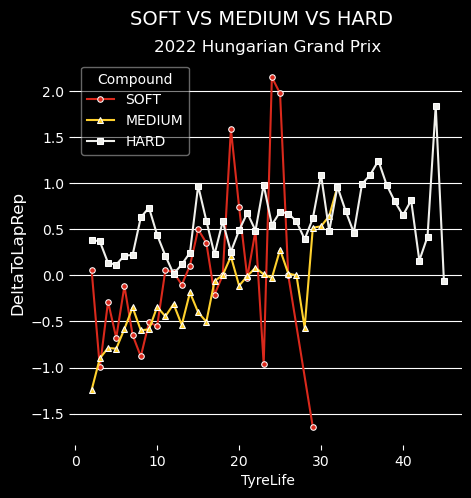

In [35]:
# How did each compound perform at the 2022 Hungary Grand Prix?
tyre_lineplot, warning_msgs = compounds_lineplot(seasons=[2022], 
                                             events=["Hungary"], 
                                             y="DeltaToLapRep", 
                                             compounds=["SOFT", "MEDIUM", "HARD"], 
                                             x="TyreLife", 
                                             upper_bound=10, 
                                             absolute_compound=False
                                            )

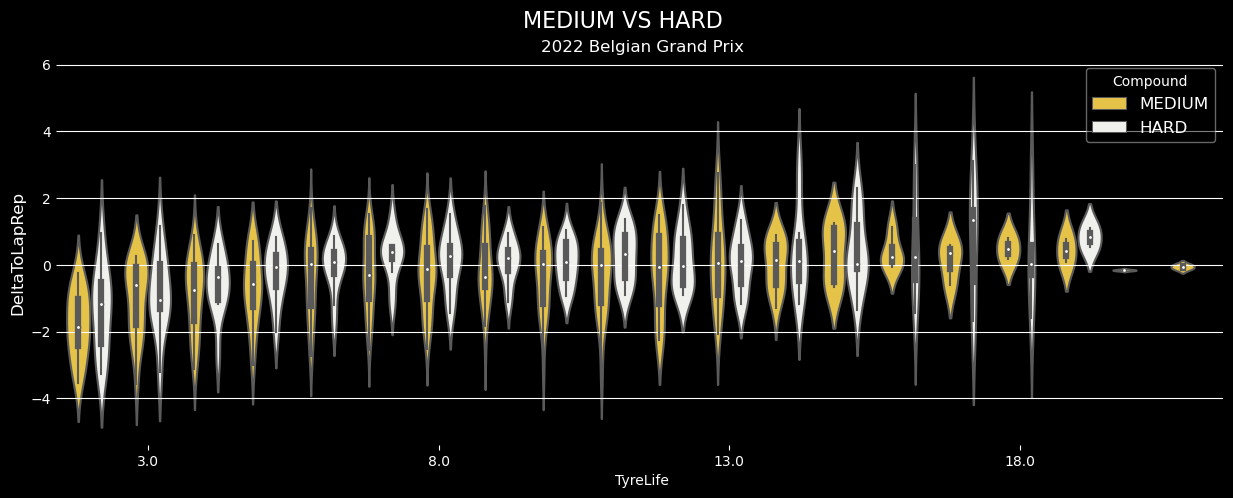

In [36]:
# How did the medium compound do vs the hard compound in the 2022 Belgian Grand Prix?
tyre_violinplot, warning_msgs = compounds_distribution(seasons=[2022], 
                                                   events=["Belgium"], 
                                                   y="DeltaToLapRep", 
                                                   compounds=["HARD", "MEDIUM"],
                                                   violin_plot=True,
                                                   x="TyreLife", 
                                                   upper_bound=10, 
                                                   absolute_compound=False
                                                  )

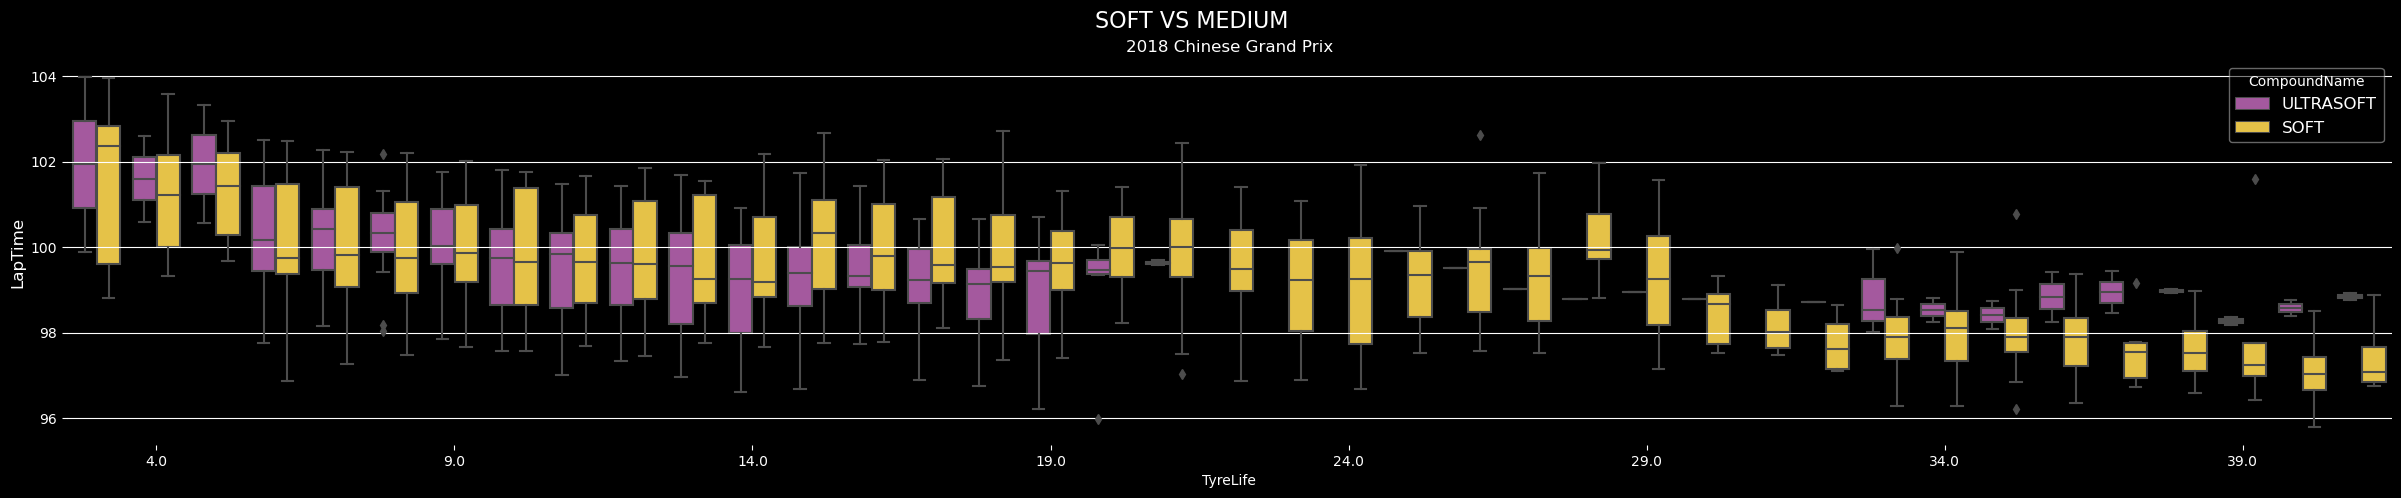

In [37]:
# Where is the crossover point between the softest and second softest compound for the 2018 Chinese Grand Prix?
tyre_boxplot, warning_msgs = compounds_distribution(seasons=[2018], 
                                                events=["China"], 
                                                y="LapTime", 
                                                compounds=["SOFT", "MEDIUM"],
                                                violin_plot=False,
                                                x="TyreLife", 
                                                upper_bound=10, 
                                                absolute_compound=True
                                               )